In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import matplotlib as mpl
from sklearn.cluster import KMeans
import dofitPython_functions as LogFit 

In [2]:
ECearth_ds = xr.open_dataset('/share/pech2273/ECEarthProcessed.nc')
NorESM_ds = xr.open_dataset('/share/pech2273/NorESMProcessed.nc')
ECCDNC_ds = xr.open_dataset('/share/pech2273/ECCDNCParsec.nc')

In [3]:
for i in range(6):
    if i == 0:
        mask = ECearth_ds['label'] == i  
        ECearth_ds['DropletsCCUp1'] = xr.where( mask, np.nan, ECearth_ds['DropletsCCUp1'])
        continue
    mask = ECearth_ds['label'] == i  
    ECearth_ds['DropletsCCUp1'] = xr.where( mask, ECearth_ds['Droplets']*(1+ECCDNC_ds['Percentage_Increase'][i]/100), ECearth_ds['DropletsCCUp1'])
for i in range(6):
    if i == 0:
        mask = ECearth_ds['label'] == i  
        ECearth_ds['DropletsCCUp2'] = xr.where( mask, np.nan, ECearth_ds['DropletsCCUp2'])
        continue
    mask = ECearth_ds['label'] == i  
    ECearth_ds['DropletsCCUp2'] = xr.where(mask, ECearth_ds['Droplets']* (1+ECCDNC_ds['Percentage_Increase'][i+6]/100), ECearth_ds['DropletsCCUp2'])
for i in range(6):
    if i == 0:
        mask = ECearth_ds['label'] == i  
        ECearth_ds['DropletsCCUp3'] = xr.where( mask, np.nan, ECearth_ds['DropletsCCUp3'])
        continue
    mask = ECearth_ds['label'] == i  
    ECearth_ds['DropletsCCUp3'] = xr.where(mask, ECearth_ds['Droplets']* (1+ECCDNC_ds['Percentage_Increase'][i+12]/100), ECearth_ds['DropletsCCUp3'])

In [51]:
def NdtoCCNGraph(x,y):
    
    x = x.to_numpy()
    y = y.to_numpy()
    Y = np.log10(y)
    X = np.log10(x)
    X = sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    res = stats.linregress(np.log10(x),np.log10(y))
    lims = [1,10000]
    fig = plt.hexbin(x,y,gridsize=50, bins= 'log', xscale='log', yscale='log',edgecolors = 'face', cmap ='inferno',extent = [0,4,0,4], mincnt = 1)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot([1,10000],[10**res.intercept*1**res.slope,10**res.intercept*10000**res.slope])
    plt.plot(lims,lims)
    plt.colorbar(label='counts')
    plt.xlabel('CCN, $cm^{-3}$')
    plt.ylabel('Nd, $cm^{-3}$')
        
    
    return fig
def Susceptibility(x,y):
    x = x.to_numpy()
    y = y.to_numpy()
    Y = np.log10(y)
    X = np.log10(x)
    X = sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    parameters = model.params
    sterrs = model.bse
    S = parameters[1]
    Sterr = sterrs[1]
    return S, Sterr
def SusceptibilityGraph(model):

    parameters = model.params
    sterrs = model.bse
    S = parameters[1]
    Sterr = sterrs[1]
    return S, Sterr

In [148]:
def TripleGraph(Cluster, level, GroupedData, CC = False, NorESM = True):

    fig, ax = plt.subplots(1, 3, figsize=(12, 4)) 
    for n in range (1,4):
        i = Cluster-1
        if NorESM == True:
            
            if CC == False:
                x = GroupedData[i][f'ActivatedNumberUpdraft{n}'].isel(lev = level).where(GroupedData[i]['Droplets'].isel(lev = level)>0).dropna('time')
                y = GroupedData[i]['Droplets'].isel(lev = level).dropna('time')
            else:
                x = GroupedData[i][f'ActivatedNumberUpdraft{n}CC'].isel(lev = level).where(GroupedData[i][f'DropletsCCUp{n}'].isel(lev = level)>0).dropna('time')
                y = GroupedData[i][f'DropletsCCUp{n}'].isel(lev = level).dropna('time')
        else:
            if CC == False:
                x = GroupedData[i][f'ActivatedNumberUpdraft{n}'].isel(lev = level).where(GroupedData[i]['Droplets'].isel(lev = level)>0).dropna('time')*1E-6
                y = GroupedData[i]['Droplets'].isel(lev = level).dropna('time')
            else:
                x = GroupedData[i][f'ActivatedNumberUpdraft{n}CC'].isel(lev = level).where(GroupedData[i][f'DropletsCCUp{n}'].isel(lev = level)>0).dropna('time')*1E-6
                y = GroupedData[i][f'DropletsCCUp{n}'].isel(lev = level).dropna('time')
        x = x.to_numpy()
        y = y.to_numpy()
        Y = np.log10(y)
        X = np.log10(x)
        X = sm.add_constant(X)
        model = sm.OLS(Y,X).fit()
        Sensitivity = SusceptibilityGraph(model)
        res = stats.linregress(np.log10(x),np.log10(y))
        lims = [1,10000]
        ax[n-1].hexbin(x,y,gridsize=50, bins= 'log', xscale='log', yscale='log',edgecolors = 'face', cmap ='inferno',extent = [0,4,0,4], mincnt = 1)
        plt.xlim(lims)
        plt.ylim(lims)
        ax[n-1].plot([1,10000],[10**res.intercept*1**res.slope,10**res.intercept*10000**res.slope])
        ax[n-1].plot(lims,lims)
        if CC == False:
            if NorESM == True:
                ax[n-1].set_title(f'NorESM Cluster {Cluster}, Updraft {n}, No CC')
            else:
                ax[n-1].set_title(f'EC-Earth Cluster {Cluster}, Updraft {n}, No CC')
        else:
            if NorESM == True:
                ax[n-1].set_title(f'NorESM Cluster {Cluster}, Updraft {n}, With CC')
            else:
                ax[n-1].set_title(f'EC-Earth Cluster {Cluster}, Updraft {n}, With CC')          
        if NorESM == True:
            ax[n-1].text(lims[1],lims[0], f'Level {abs(level)}',ha="right", va="bottom")
        else:
            ax[n-1].text(lims[1],lims[0],  f'Level {level+1}',ha="right", va="bottom")
        if NorESM == True and CC == False:
            ax[n-1].text(2,5000, f'Activation Radius = {NorActR_df.iloc[n-1].values[i]:.2f} nm')
        if NorESM == True and CC == True:
            ax[n-1].text(2,5000, f'Activation Radius = {NorActR_CC_df.iloc[n-1].values[i]:.2f} nm')
        if NorESM == False and CC == False:
            ax[n-1].text(2,5000, f'Activation Radius = {ECActR_df.iloc[n-1].values[i]:.2f} nm')
        if NorESM == False and CC == True:   
            ax[n-1].text(2,5000, f'Activation Radius = {ECActR_CC_df.iloc[n-1].values[i]:.2f} nm')
            
        ax[n-1].text(2,2500,f'Susceptibility = {Sensitivity[0]:.3f} +/- {Sensitivity[1]:.3f}')     
    plt.tight_layout()

In [149]:
ECActR = [np.nan, 
 np.float64(203.16583101639702),
 np.float64(141.33523429255584),
 np.float64(251.5108263233402),
 np.float64(304.7839531499037),
 np.float64(141.33523429255584),
 np.float64(268.14425005353365),
 np.float64(124.34457265169122),
 np.float64(92.22282316159196),
 np.float64(160.6475298965127),
 np.float64(203.16583101639702),
 np.float64(96.24531891583946),
 np.float64(207.54929878718698),
 np.float64(98.3218898207321),
 np.float64(76.1032141604749),
 np.float64(121.71839935273819),
 np.float64(157.25463349130524),
 np.float64(81.13622616582478)]
ECActR = np.array(ECActR).reshape(3, 6)

ECActR_df = pd.DataFrame(ECActR, columns=["Cluster 1", "Cluster 2", "Cluster 3","Cluster 4", "Cluster 5", "Cluster 6"], index =['Updraft 1', 'Updraft2', 'Updraft 3'])

In [150]:
ECActR_df

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6
Updraft 1,NaN,203.165831,141.335234,251.510826,304.783953,141.335234
Updraft2,268.144250,124.344573,92.222823,160.647530,203.165831,96.245319
Updraft 3,207.549299,98.321890,76.103214,121.718399,157.254633,81.136226


In [192]:
ECActR_CC = [np.nan,
 np.float64(190.56312424898383),
 np.float64(127.02740777196964),
 np.float64(240.99913346981475),
 np.float64(285.87770907458366),
 np.float64(127.02740777196964),
 np.float64(207.54929878718698),
 np.float64(102.61040941702),
 np.float64(72.92254148679628),
 np.float64(141.33523429255584),
 np.float64(186.53840665982455),
 np.float64(77.74520280028237),
 np.float64(144.38465673381506),
 np.float64(74.49590453102621),
 np.float64(57.66139958192239),
 np.float64(98.3218898207321),
 np.float64(132.5679799526813),
 np.float64(64.15613419567872)]
ECActR_CC = np.array(ECActR_CC).reshape(3, 6)

ECActR_CC_df = pd.DataFrame(ECActR_CC, columns=["Cluster 1", "Cluster 2", "Cluster 3","Cluster 4", "Cluster 5", "Cluster 6"], index =['Updraft 1', 'Updraft2', 'Updraft 3'])
ECActR_CC_df

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6
Updraft 1,NaN,190.563124,127.027408,240.999133,285.877709,127.027408
Updraft2,207.549299,102.610409,72.922541,141.335234,186.538407,77.745203
Updraft 3,144.384657,74.495905,57.661400,98.321890,132.567980,64.156134


In [182]:
NorActR = [np.float64(171.27179794508717),
 np.float64(129.7681272383768),
 np.float64(226.04956544882387),
 np.float64(82.88680612635326),
 np.float64(127.02740777196964),
 np.float64(92.22282316159196),
 np.float64(174.96712605504354),
 np.float64(60.17642489833283),
 np.float64(107.08598197131427),
 np.float64(79.42261867825579),
 np.float64(147.49987294031467),
 np.float64(50.72961548053402)]
NorActR= np.array(NorActR).reshape(3, 4)

NorActR_df = pd.DataFrame(NorActR, columns=["Cluster 1", "Cluster 2", "Cluster 3","Cluster 4"], index =['Updraft 1', 'Updraft2', 'Updraft 3'])

In [183]:
NorActR_CC = [np.float64(167.65451563806593),
 np.float64(121.71839935273819),
 np.float64(221.2753696768497),
 np.float64(74.49590453102621),
 np.float64(119.14769117018751),
 np.float64(82.88680612635326),
 np.float64(171.27179794508717),
 np.float64(54.08456923060725),
 np.float64(98.3218898207321),
 np.float64(68.39903769437733),
 np.float64(138.3502160437893),
 np.float64(46.57782066434512)]
NorActR_CC= np.array(NorActR_CC).reshape(3, 4)

NorActR_CC_df = pd.DataFrame(NorActR_CC, columns=["Cluster 1", "Cluster 2", "Cluster 3","Cluster 4"], index =['Updraft 1', 'Updraft2', 'Updraft 3'])

In [184]:
NorActR_df.iloc[1].values[0]

np.float64(127.02740777196964)

In [155]:
NorGroup = NorESM_ds.groupby(NorESM_ds['label'])
ECGroup = ECearth_ds.groupby(ECearth_ds['label'])

In [156]:
for i in range(0,4):
    print(len(NorGroup[i]['Droplets'].isel(lev = -3).dropna('time')))
print('BREAK')
for i in range(0,6):
    print(len(ECGroup[i]['Droplets'].isel(lev = 0).dropna('time')))

34
175
0
1520
BREAK
177
2403
2058
1574
740
143


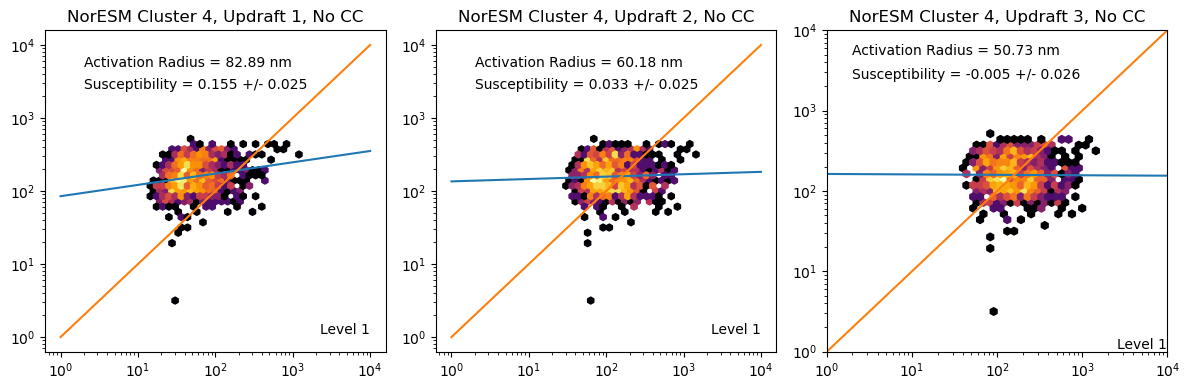

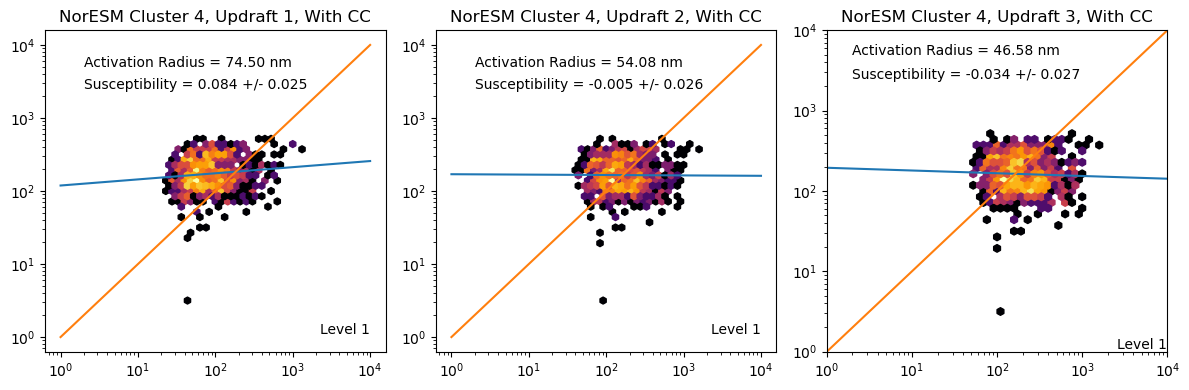

In [157]:
TripleGraph(Cluster = 4, level = -1, GroupedData = NorGroup, CC = False, NorESM = True)
TripleGraph(Cluster = 4, level = -1, GroupedData = NorGroup, CC = True, NorESM = True)


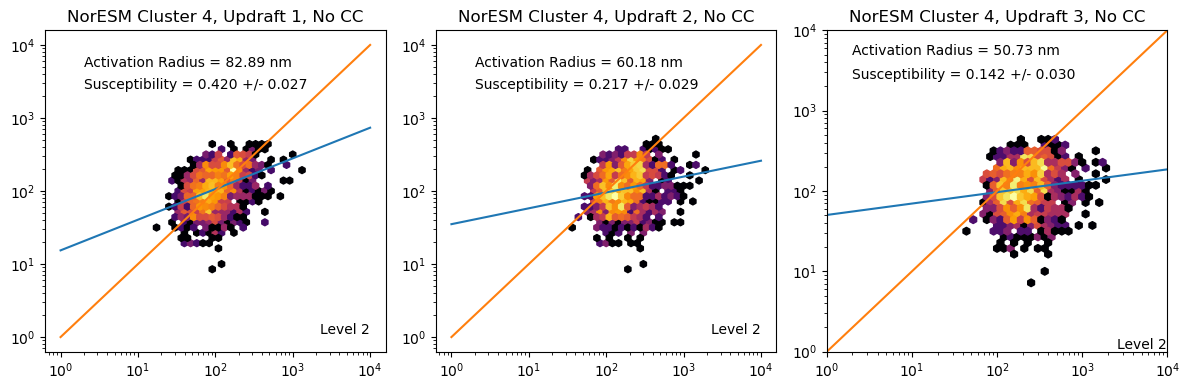

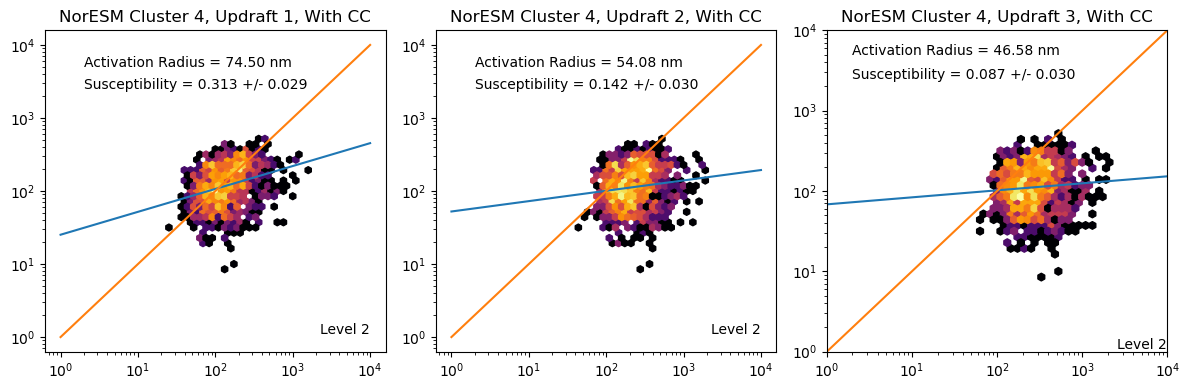

In [158]:
TripleGraph(Cluster = 4, level = -2, GroupedData = NorGroup, CC = False, NorESM = True)
TripleGraph(Cluster = 4, level = -2, GroupedData = NorGroup, CC = True, NorESM = True)


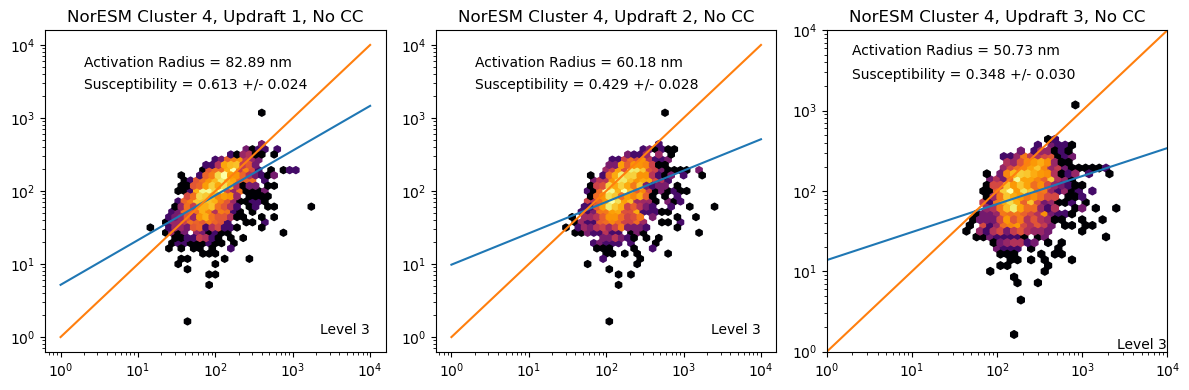

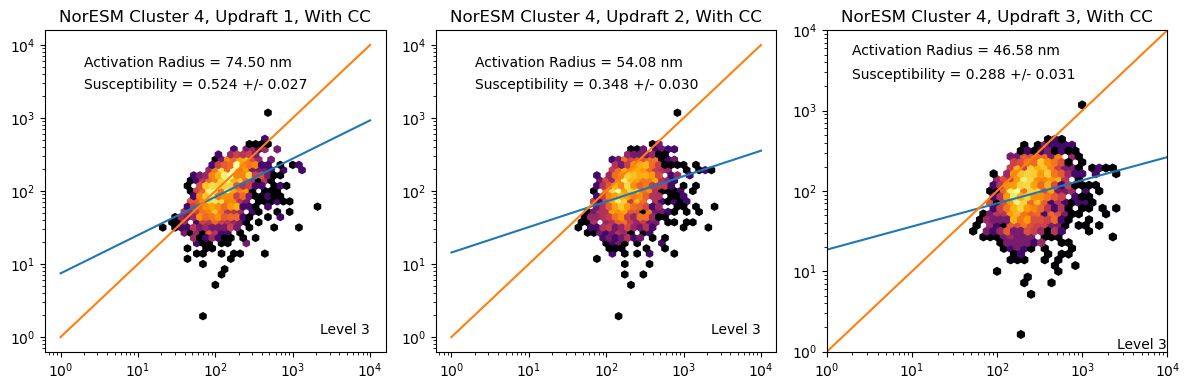

In [159]:
TripleGraph(Cluster = 4, level = -3, GroupedData = NorGroup, CC = False, NorESM = True)
TripleGraph(Cluster = 4, level = -3, GroupedData = NorGroup, CC = True, NorESM = True)


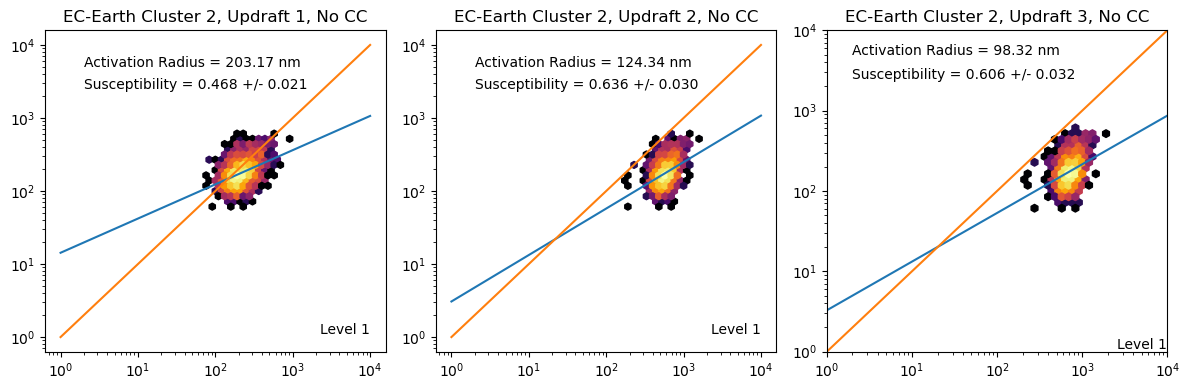

In [160]:
TripleGraph(Cluster = 2, level = 0, GroupedData = ECGroup, CC = False, NorESM = False)


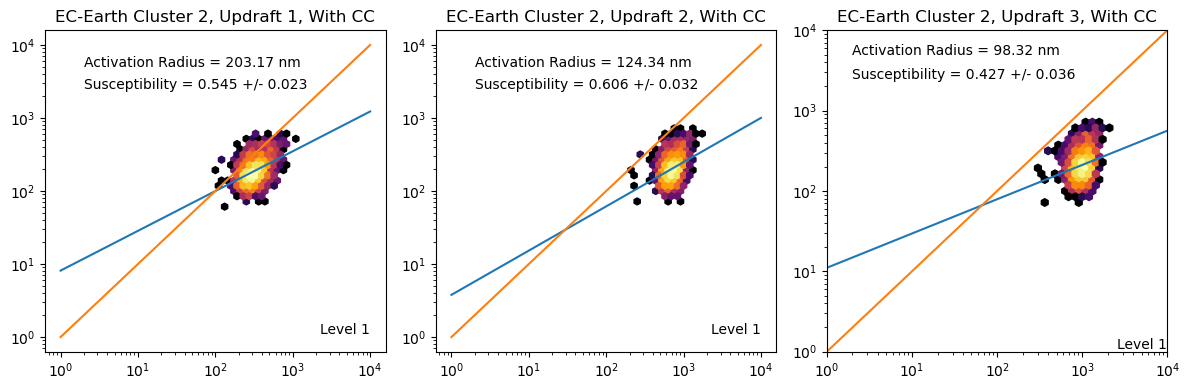

In [161]:
TripleGraph(Cluster = 2, level = 0, GroupedData = ECGroup, CC = True, NorESM = False)

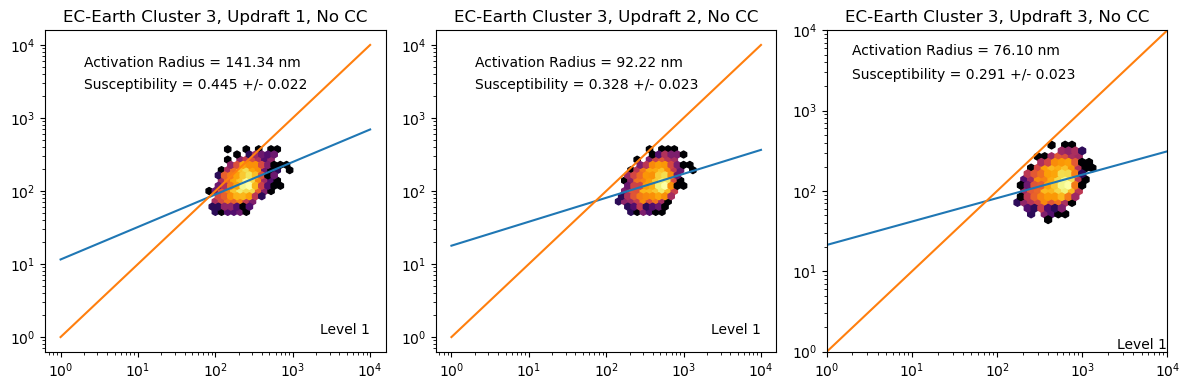

In [162]:
TripleGraph(Cluster = 3, level = 0, GroupedData = ECGroup, CC = False, NorESM = False)

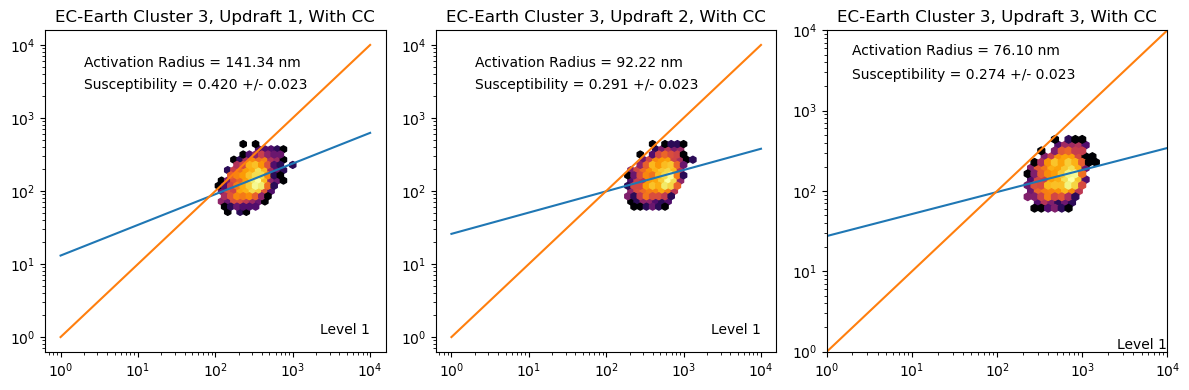

In [163]:
TripleGraph(Cluster = 3, level = 0, GroupedData = ECGroup, CC = True, NorESM = False)

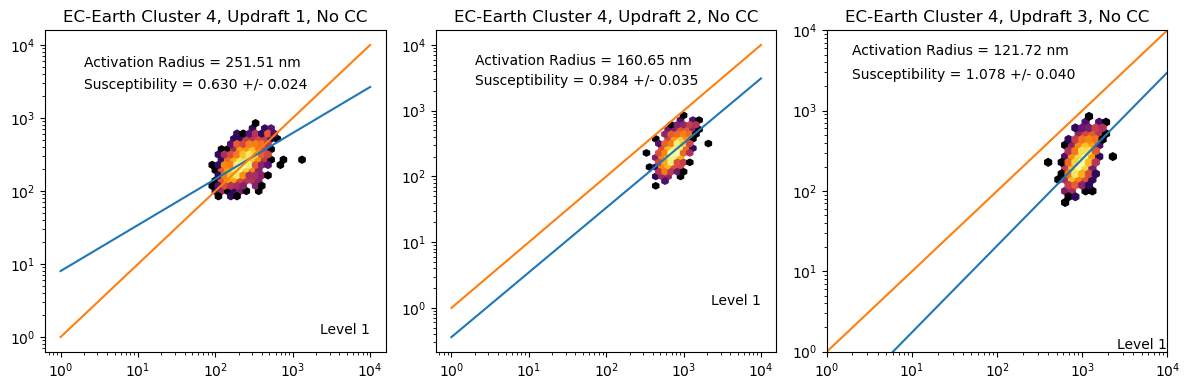

In [164]:
TripleGraph(Cluster = 4, level = 0, GroupedData = ECGroup, CC = False, NorESM = False)

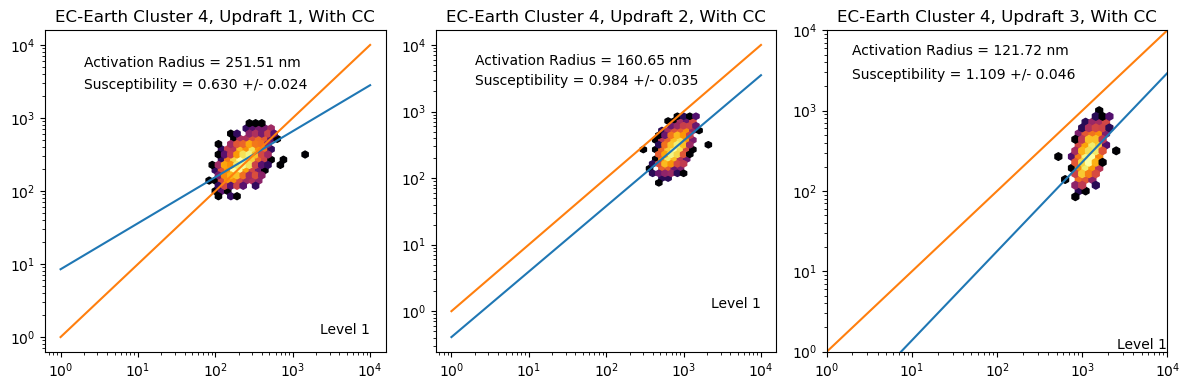

In [165]:
TripleGraph(Cluster = 4, level = 0, GroupedData = ECGroup, CC = True, NorESM = False)

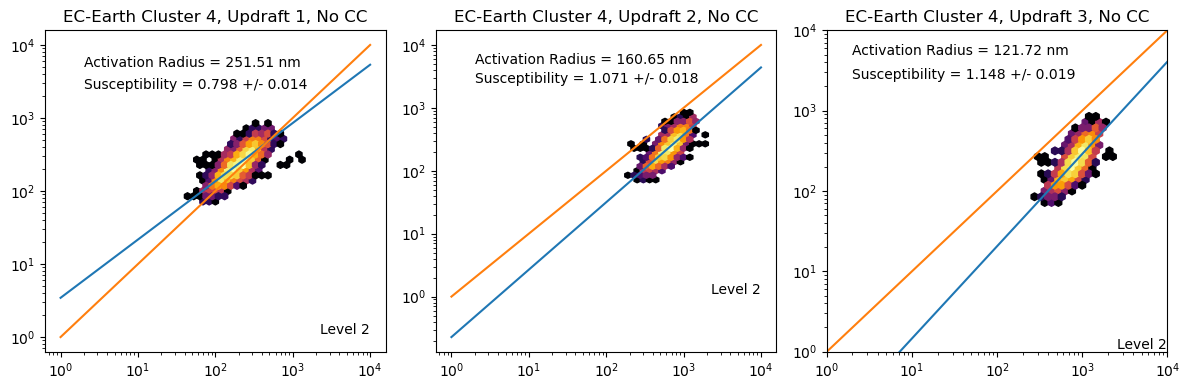

In [166]:
TripleGraph(Cluster = 4, level = 1, GroupedData = ECGroup, CC = False, NorESM = False)

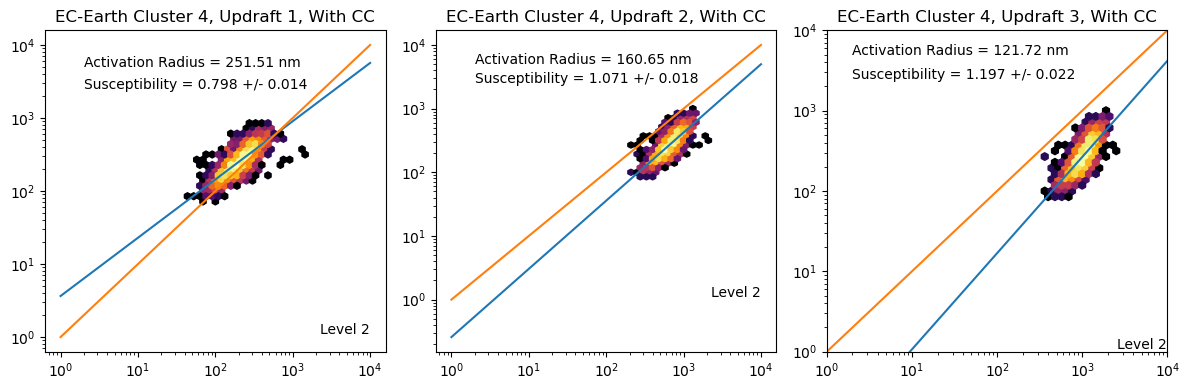

In [167]:
TripleGraph(Cluster = 4, level = 1, GroupedData = ECGroup, CC = True, NorESM = False)

In [168]:
ECCDNC_ds['Percentage_Increase'].values

array([        nan,  7.        ,  9.66183575,  5.83756345, 12.5       ,
       11.61616162, 24.87205732, 15.61181435, 21.45214521, 13.4375    ,
       10.05025126, 38.03278689, 33.66418528, 20.03546099, 20.50561798,
       15.53884712, 14.1       , 35.78947368])

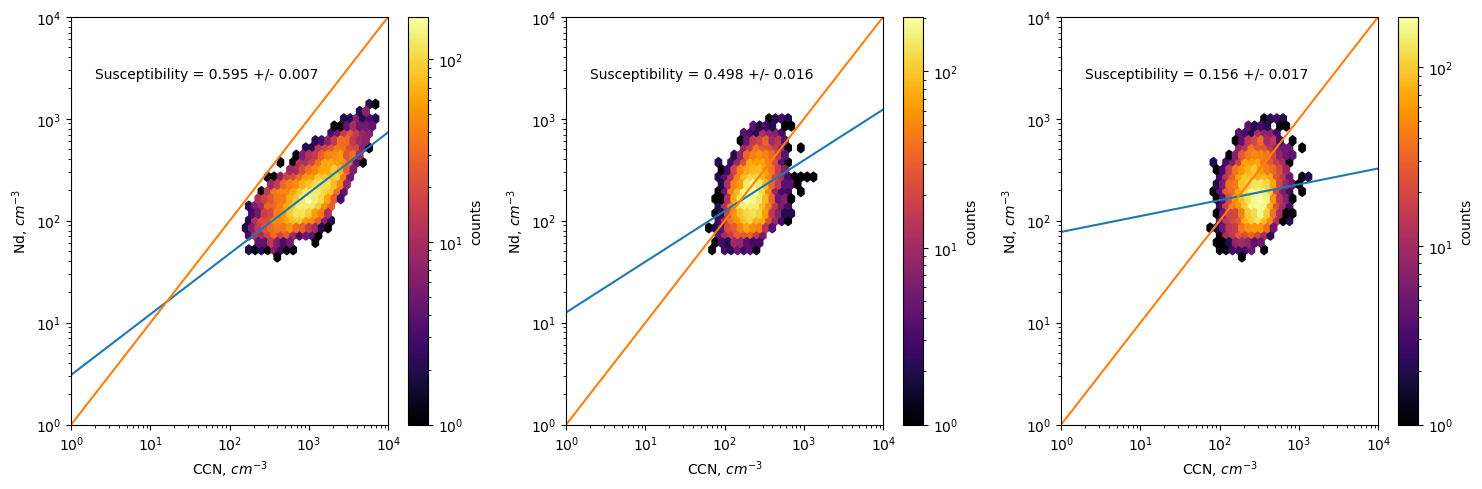

In [169]:
plt.figure(figsize = (15,5))
x = ECearth_ds['TotN70'].isel(lev = 0).where(ECearth_ds['Droplets'].isel(lev =0)>0).dropna('time')/10**6
y = ECearth_ds['Droplets'].isel(lev = 0).where(ECearth_ds['Droplets'].isel(lev =0)>0).dropna('time')
plt.subplot(1,3,1)
SBaseLev1 = Susceptibility(x,y)
plt.text(2,2500,f'Susceptibility = {SBaseLev1[0]:.3f} +/- {SBaseLev1[1]:.3f}')     
NdtoCCNGraph(x,y)
x =ECearth_ds['ActivatedNumberUpdraft1'].isel(lev = 0).where(ECearth_ds['Droplets'].isel(lev =0)>0).dropna('time')/10**6
y = ECearth_ds['Droplets'].isel(lev = 0).where((ECearth_ds['Droplets'].isel(lev =0)>0) & (ECearth_ds['ActivatedNumberUpdraft1'].isel(lev = 0)>0)).dropna('time')
plt.subplot(1,3,2)
ActivatedSensitivity = Susceptibility(x,y)
plt.text(2,2500,f'Susceptibility = {ActivatedSensitivity[0]:.3f} +/- {ActivatedSensitivity[1]:.3f}')    
NdtoCCNGraph(x,y)
x = ECearth_ds['ActivatedNumberUpdraft1CC'].isel(lev = 0).where(ECearth_ds['Droplets'].isel(lev =0)>0).dropna('time')/10**6
y = ECearth_ds['Droplets'].isel(lev = 0).where((ECearth_ds['Droplets'].isel(lev =0)>0) & (ECearth_ds['ActivatedNumberUpdraft1CC'].isel(lev = 0)>0)).dropna('time')
plt.subplot(1,3,3)
ActivatedSensitivityCC = Susceptibility(x,y)
plt.text(2,2500,f'Susceptibility = {ActivatedSensitivityCC[0]:.3f} +/- {ActivatedSensitivityCC[1]:.3f}')    

NdtoCCNGraph(x,y)
plt.tight_layout()

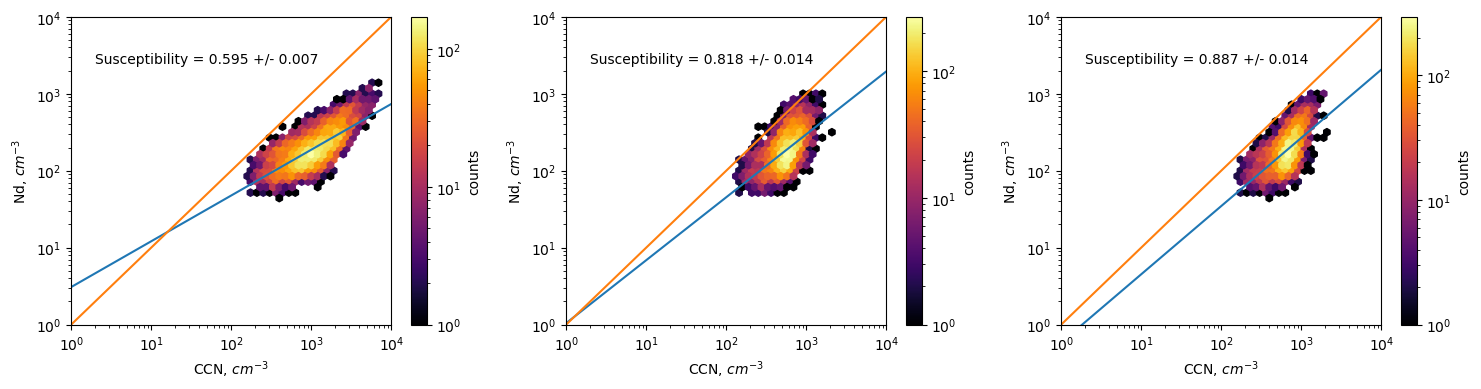

In [170]:
plt.figure(figsize = (15,4))
x = ECearth_ds['TotN70'].isel(lev = 0).where(ECearth_ds['Droplets'].isel(lev =0)>0).dropna('time')/10**6
y = ECearth_ds['Droplets'].isel(lev = 0).where(ECearth_ds['Droplets'].isel(lev =0)>0).dropna('time')
plt.subplot(1,3,1)
SBaseLev1 = Susceptibility(x,y)
plt.text(2,2500,f'Susceptibility = {SBaseLev1[0]:.3f} +/- {SBaseLev1[1]:.3f}')     
NdtoCCNGraph(x,y)
x =ECearth_ds['ActivatedNumberUpdraft2'].isel(lev = 0).where(ECearth_ds['Droplets'].isel(lev =0)>0).dropna('time')/10**6
y = ECearth_ds['Droplets'].isel(lev = 0).where((ECearth_ds['Droplets'].isel(lev =0)>0) & (ECearth_ds['ActivatedNumberUpdraft2'].isel(lev = 0)>0)).dropna('time')
plt.subplot(1,3,2)
ActivatedSensitivity = Susceptibility(x,y)
plt.text(2,2500,f'Susceptibility = {ActivatedSensitivity[0]:.3f} +/- {ActivatedSensitivity[1]:.3f}')    
NdtoCCNGraph(x,y)
x = ECearth_ds['ActivatedNumberUpdraft2CC'].isel(lev = 0).where(ECearth_ds['Droplets'].isel(lev =0)>0).dropna('time')/10**6
y = ECearth_ds['Droplets'].isel(lev = 0).where((ECearth_ds['Droplets'].isel(lev =0)>0) & (ECearth_ds['ActivatedNumberUpdraft2CC'].isel(lev = 0)>0)).dropna('time')
plt.subplot(1,3,3)
ActivatedSensitivityCC = Susceptibility(x,y)
plt.text(2,2500,f'Susceptibility = {ActivatedSensitivityCC[0]:.3f} +/- {ActivatedSensitivityCC[1]:.3f}')    

NdtoCCNGraph(x,y)
plt.tight_layout()

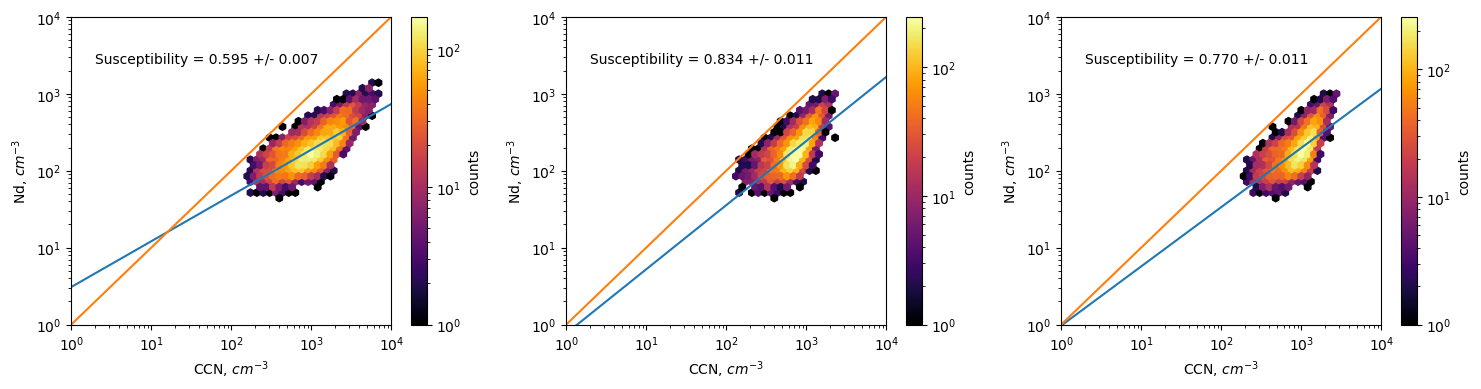

In [171]:
plt.figure(figsize = (15,4))
x = ECearth_ds['TotN70'].isel(lev = 0).where(ECearth_ds['Droplets'].isel(lev =0)>0).dropna('time')/10**6
y = ECearth_ds['Droplets'].isel(lev = 0).where(ECearth_ds['Droplets'].isel(lev =0)>0).dropna('time')
plt.subplot(1,3,1)
SBaseLev1 = Susceptibility(x,y)
plt.text(2,2500,f'Susceptibility = {SBaseLev1[0]:.3f} +/- {SBaseLev1[1]:.3f}')     
NdtoCCNGraph(x,y)
x =ECearth_ds['ActivatedNumberUpdraft3'].isel(lev = 0).where(ECearth_ds['Droplets'].isel(lev =0)>0).dropna('time')/10**6
y = ECearth_ds['Droplets'].isel(lev = 0).where((ECearth_ds['Droplets'].isel(lev =0)>0) & (ECearth_ds['ActivatedNumberUpdraft3'].isel(lev = 0)>0)).dropna('time')
plt.subplot(1,3,2)
ActivatedSensitivity = Susceptibility(x,y)
plt.text(2,2500,f'Susceptibility = {ActivatedSensitivity[0]:.3f} +/- {ActivatedSensitivity[1]:.3f}')    
NdtoCCNGraph(x,y)
x = ECearth_ds['ActivatedNumberUpdraft3CC'].isel(lev = 0).where(ECearth_ds['Droplets'].isel(lev =0)>0).dropna('time')/10**6
y = ECearth_ds['Droplets'].isel(lev = 0).where((ECearth_ds['Droplets'].isel(lev =0)>0) & (ECearth_ds['ActivatedNumberUpdraft3CC'].isel(lev = 0)>0)).dropna('time')
plt.subplot(1,3,3)
ActivatedSensitivityCC = Susceptibility(x,y)
plt.text(2,2500,f'Susceptibility = {ActivatedSensitivityCC[0]:.3f} +/- {ActivatedSensitivityCC[1]:.3f}')    

NdtoCCNGraph(x,y)
plt.tight_layout()

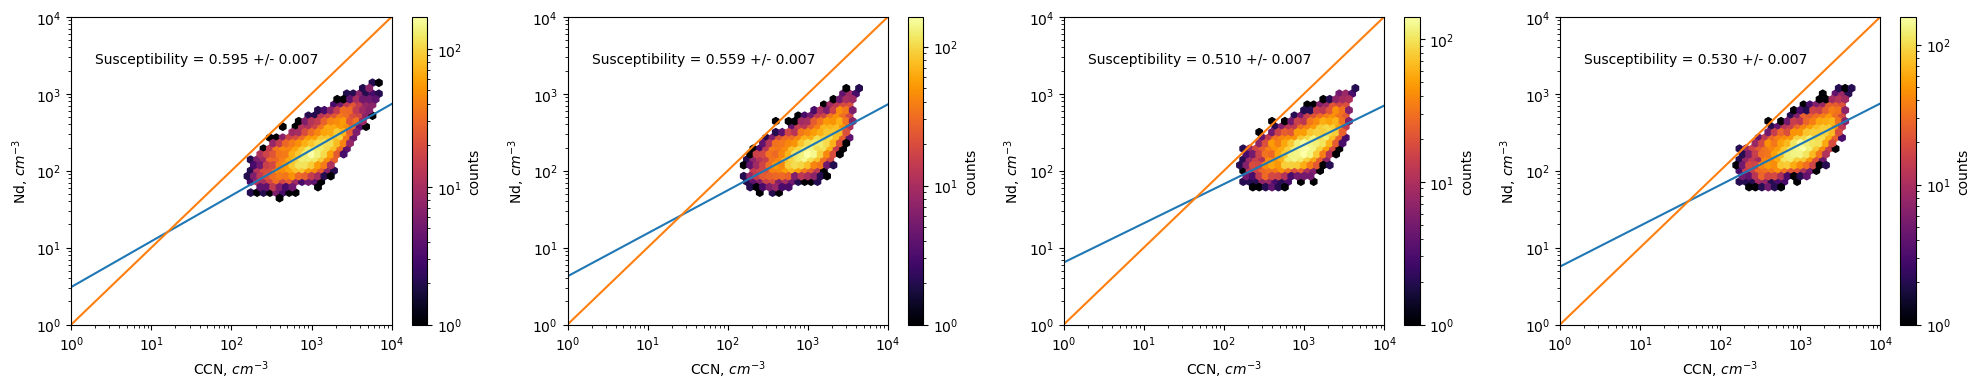

In [172]:
plt.figure(figsize = (20,4))
x = ECearth_ds['TotN70'].isel(lev = 0).where(ECearth_ds['Droplets'].isel(lev =0)>0).dropna('time')/10**6
y = ECearth_ds['Droplets'].isel(lev = 0).where(ECearth_ds['Droplets'].isel(lev =0)>0).dropna('time')
plt.subplot(1,4,1)
SBaseLev1 = Susceptibility(x,y)
plt.text(2,2500,f'Susceptibility = {SBaseLev1[0]:.3f} +/- {SBaseLev1[1]:.3f}')     
NdtoCCNGraph(x,y)
x =ECearth_ds['TotN70'].isel(lev = 0).where(ECearth_ds['DropletsCCUp1'].isel(lev =0)>0).dropna('time')/10**6
y = ECearth_ds['DropletsCCUp1'].isel(lev = 0).where((ECearth_ds['DropletsCCUp1'].isel(lev =0)>0) & (ECearth_ds['TotN70'].isel(lev = 0)>0)).dropna('time')
plt.subplot(1,4,2)
ActivatedSensitivity = Susceptibility(x,y)
plt.text(2,2500,f'Susceptibility = {ActivatedSensitivity[0]:.3f} +/- {ActivatedSensitivity[1]:.3f}')    
NdtoCCNGraph(x,y)
x = ECearth_ds['TotN70'].isel(lev = 0).where(ECearth_ds['DropletsCCUp2'].isel(lev =0)>0).dropna('time')/10**6
y = ECearth_ds['DropletsCCUp2'].isel(lev = 0).where((ECearth_ds['DropletsCCUp2'].isel(lev =0)>0) & (ECearth_ds['TotN70'].isel(lev = 0)>0)).dropna('time')
plt.subplot(1,4,3)
ActivatedSensitivityCC = Susceptibility(x,y)
plt.text(2,2500,f'Susceptibility = {ActivatedSensitivityCC[0]:.3f} +/- {ActivatedSensitivityCC[1]:.3f}')    
NdtoCCNGraph(x,y)

x = ECearth_ds['TotN70'].isel(lev = 0).where(ECearth_ds['DropletsCCUp3'].isel(lev =0)>0).dropna('time')/10**6
y = ECearth_ds['DropletsCCUp3'].isel(lev = 0).where((ECearth_ds['DropletsCCUp3'].isel(lev =0)>0) & (ECearth_ds['TotN70'].isel(lev = 0)>0)).dropna('time')
plt.subplot(1,4,4)
ActivatedSensitivityCC = Susceptibility(x,y)
plt.text(2,2500,f'Susceptibility = {ActivatedSensitivityCC[0]:.3f} +/- {ActivatedSensitivityCC[1]:.3f}')    
NdtoCCNGraph(x,y)
plt.tight_layout()

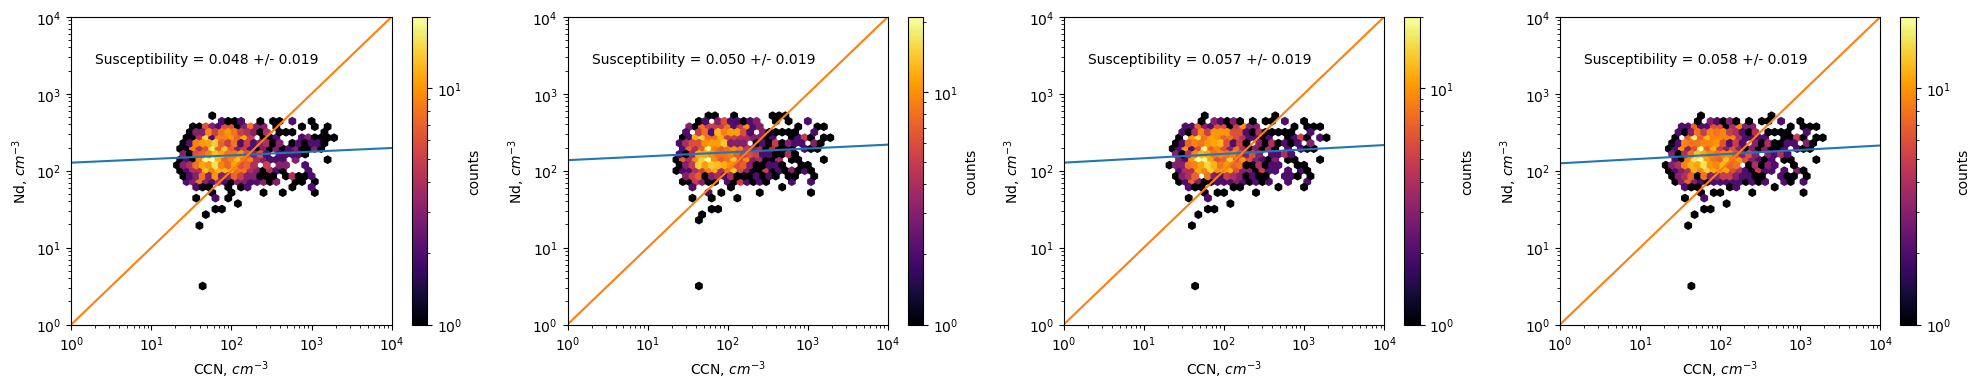

In [173]:
plt.figure(figsize = (20,4))
x = NorESM_ds['TotN70'].isel(lev = -1).where(NorESM_ds['Droplets'].isel(lev =-1)>0).dropna('time')
y = NorESM_ds['Droplets'].isel(lev = -1).where(NorESM_ds['Droplets'].isel(lev =-1)>0).dropna('time')
plt.subplot(1,4,1)
SBaseLev1 = Susceptibility(x,y)
plt.text(2,2500,f'Susceptibility = {SBaseLev1[0]:.3f} +/- {SBaseLev1[1]:.3f}')     
NdtoCCNGraph(x,y)
x =NorESM_ds['TotN70'].isel(lev = -1).where(NorESM_ds['DropletsCCUp1'].isel(lev =-1)>0).dropna('time')
y = NorESM_ds['DropletsCCUp1'].isel(lev = -1).where((NorESM_ds['DropletsCCUp1'].isel(lev =-1)>0) & (NorESM_ds['TotN70'].isel(lev = 0)>0)).dropna('time')
plt.subplot(1,4,2)
ActivatedSensitivity = Susceptibility(x,y)
plt.text(2,2500,f'Susceptibility = {ActivatedSensitivity[0]:.3f} +/- {ActivatedSensitivity[1]:.3f}')    
NdtoCCNGraph(x,y)
x = NorESM_ds['TotN70'].isel(lev = -1).where(NorESM_ds['DropletsCCUp2'].isel(lev =-1)>0).dropna('time')
y = NorESM_ds['DropletsCCUp2'].isel(lev = -1).where((NorESM_ds['DropletsCCUp2'].isel(lev =-1)>0) & (NorESM_ds['TotN70'].isel(lev = 0)>0)).dropna('time')
plt.subplot(1,4,3)
ActivatedSensitivityCC = Susceptibility(x,y)
plt.text(2,2500,f'Susceptibility = {ActivatedSensitivityCC[0]:.3f} +/- {ActivatedSensitivityCC[1]:.3f}')    
NdtoCCNGraph(x,y)

x = NorESM_ds['TotN70'].isel(lev = -1).where(NorESM_ds['DropletsCCUp3'].isel(lev =-1)>0).dropna('time')
y = NorESM_ds['DropletsCCUp3'].isel(lev = -1).where((NorESM_ds['DropletsCCUp3'].isel(lev =-1)>0) & (NorESM_ds['TotN70'].isel(lev = 0)>0)).dropna('time')
plt.subplot(1,4,4)
ActivatedSensitivityCC = Susceptibility(x,y)
plt.text(2,2500,f'Susceptibility = {ActivatedSensitivityCC[0]:.3f} +/- {ActivatedSensitivityCC[1]:.3f}')    
NdtoCCNGraph(x,y)
plt.tight_layout()

clUSTER size distribution and Critical radius visualization

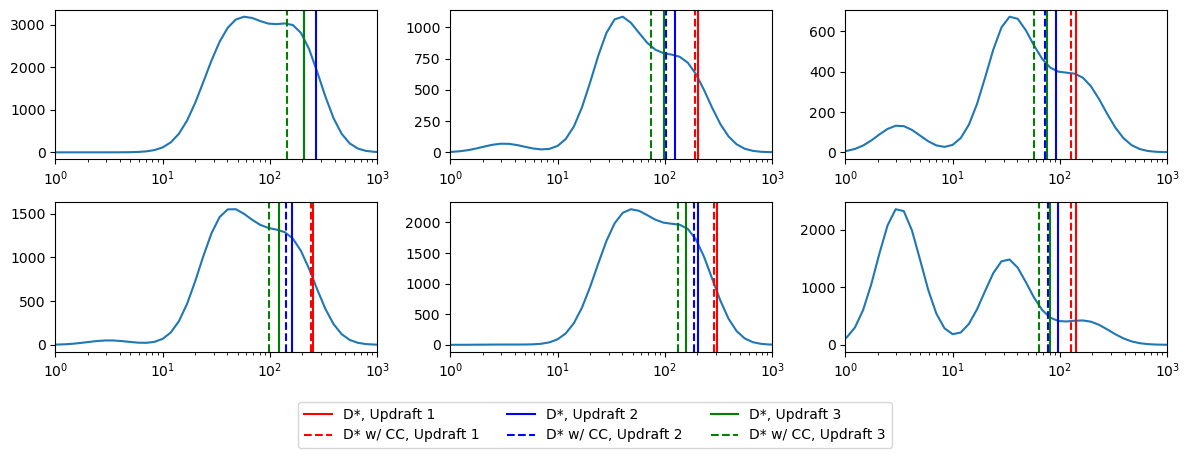

In [191]:
fig, ax = plt.subplots(2, 3, figsize=(12, 4)) 
colors = ['red','blue','green']
legend_handles = []
for i, axis in enumerate(ax.flatten()):
    axis.plot(ECGroup[i]['D'],ECGroup[i]['Tot_dis'].isel(lev = 0).mean('time')/1E6)
    axis.set_xscale('log')
    axis.set_xlim([1,1000])

    for n in range(3):
        h1 = axis.axvline(ECActR_df.iloc[n,i], color = colors[n], label = f'D*, Updraft {n+1}')
        h2 = axis.axvline(ECActR_CC_df.iloc[n,i], color = colors[n], ls = '--', label = f'D* w/ CC, Updraft {n+1}')
        if i == 0:

            legend_handles.extend([h1, h2])
            
fig.legend(handles=legend_handles, loc="lower center", bbox_to_anchor=(0.5,-0.15), ncol = 3)
plt.subplots_adjust(bottom=0.25)  
plt.tight_layout()
plt.show()
        

    
    


uncertainty whisker plots for susceptibility
Name_ls = [EC1Up1NoCC_ds, EC2Up1NoCC_ds,EC3Up1NoCC_ds,EC4Up1NoCC_ds,EC5Up1NoCC_ds,EC6Up1NoCC_ds,EC1Up2NoCC_ds, EC2Up2NoCC_ds,EC3Up2NoCC_ds,EC4Up2NoCC_ds,EC5Up2NoCC_ds,EC6Up2NoCC_ds,\
           EC1Up3NoCC_ds,EC2Up3NoCC_ds,EC3Up3NoCC_ds,EC4Up3NoCC_ds,EC5Up3NoCC_ds,EC6Up3NoCC_ds,\

           0,6,12
           1,7,13
           

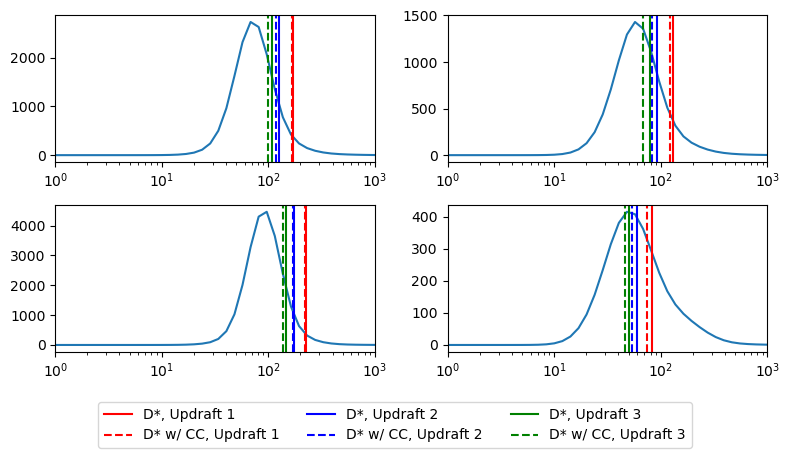

In [196]:
fig, ax = plt.subplots(2, 2, figsize=(8, 4)) 
colors = ['red','blue','green']
legend_handles = []
for i, axis in enumerate(ax.flatten()):
    axis.plot(NorGroup[i]['D'],NorGroup[i]['Tot_dis'].isel(lev = -1).mean('time'))
    axis.set_xscale('log')
    axis.set_xlim([1,1000])

    for n in range(3):
        h1 = axis.axvline(NorActR_df.iloc[n,i], color = colors[n], label = f'D*, Updraft {n+1}')
        h2 = axis.axvline(NorActR_CC_df.iloc[n,i], color = colors[n], ls = '--', label = f'D* w/ CC, Updraft {n+1}')
        if i == 0:

            legend_handles.extend([h1, h2])
            
fig.legend(handles=legend_handles, loc="lower center", bbox_to_anchor=(0.5,-0.15), ncol = 3)
plt.subplots_adjust(bottom=0.25)  
plt.tight_layout()
plt.show()